<a href="https://colab.research.google.com/github/AIFahim/Bangla-News-Article-Classification/blob/master/Evaluation_of_Glove_Model_Multiple_LSTM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Google Drive Mount

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Importing required Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
import re
from nltk.tokenize import word_tokenize
import gensim
import string

from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,GRU
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

import plotly.express as px

import zipfile



import tensorflow.keras as keras 
import tensorflow as tf
import tensorflow_hub as hub



class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Loading the data and getting besic information about data

In [ ]:
# Download Dataset
!gdown --id 1boKJGs-XUWsxz6JocgU7wyhf8nSayr7k # train csv
!gdown --id 1WLTPLk8oJ0XDduXnzLmxM3xwlChsgs81 # test csv
!gdown --id 1-6MlDGVEZlLFQliVL6Hgxee1wnpi_yeG # full data csv after added new clean text column

Downloading...
From: https://drive.google.com/uc?id=1boKJGs-XUWsxz6JocgU7wyhf8nSayr7k
To: /content/train.csv
100% 859M/859M [00:06<00:00, 134MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1WLTPLk8oJ0XDduXnzLmxM3xwlChsgs81
To: /content/test.csv
100% 854M/854M [00:05<00:00, 159MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-6MlDGVEZlLFQliVL6Hgxee1wnpi_yeG
To: /content/fulldata.csv
100% 2.39G/2.39G [00:17<00:00, 137MB/s]


In [ ]:
train= pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')
fulldata = pd.read_csv("/content/fulldata.csv")

In [ ]:
fulldata.head()

,Unnamed: 0,category,text,cleanText,new_clean_text
0,0,education,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...,অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যোগাযোগ প্রযুক্ত...
1,1,sports,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...,স্পিন স্পিন স্পিন লর্ডসে ইয়াসির শাহ্ লেগ স্পিন...
2,2,international,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...,সিরিয়ার পশ্চিমাঞ্চলে গতকাল রোববার বিমান হামলা...
3,3,international,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের ইউসিটি...
4,4,technology,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ডিজিটাল কেওয়াইস...


In [ ]:
fulldata.columns

Index(['Unnamed: 0', 'category', 'text', 'cleanText', 'new_clean_text'], dtype='object')

In [ ]:
fulldata.pop('Unnamed: 0') # Remove unexpected column

0             0
1             1
2             2
3             3
4             4
          ...  
197762    98878
197763    98879
197764    98880
197765    98881
197766    98882
Name: Unnamed: 0, Length: 197767, dtype: int64

In [ ]:
fulldata.head()

,category,text,cleanText,new_clean_text
0,education,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...,অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যোগাযোগ প্রযুক্ত...
1,sports,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...,স্পিন স্পিন স্পিন লর্ডসে ইয়াসির শাহ্ লেগ স্পিন...
2,international,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...,সিরিয়ার পশ্চিমাঞ্চলে গতকাল রোববার বিমান হামলা...
3,international,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের ইউসিটি...
4,technology,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ডিজিটাল কেওয়াইস...


## Preprocessing

### Convert Categories String to  Categories Number 

In [ ]:
def label_encoding(dataset,bool):
  '''
  This function will convert categorical class names into a numeric label

  Args:
  dataset: A dataset
  bool : a boolean (True or False)

  returns:
  labels: encoded labels 
  '''
  le = LabelEncoder()
  le.fit(dataset.category)
  encoded_labels = le.transform(dataset.category)
  labels = np.array(encoded_labels) # Converting into numpy array
  class_names =le.classes_ ## Define the class names again
  if bool == True:
    print(color.BOLD+"\n\t\t\t===== Label Encoding ====="+color.END,"\nClass Names:-->",le.classes_)
  return labels 

In [ ]:
labels = label_encoding(fulldata,True)


			===== Label Encoding ===== 
Class Names:--> ['economy' 'education' 'entertainment' 'international' 'sports' 'state'
 'technology']


### Glove for Vectorization

Use Glove pretrained corpus model to represent words.

In [ ]:
!gdown --id 1hau9l8myQOVF2cR4GBPeCtUDi5UOk1_P # Download Bengali GloVe Word Vectors

Downloading...
From: https://drive.google.com/uc?id=1hau9l8myQOVF2cR4GBPeCtUDi5UOk1_P
To: /content/bn_glove.39M.100d.txt
100% 173M/173M [00:01<00:00, 111MB/s] 


In [ ]:
# import and define Blnp for tokenizer
!pip install bnlp_toolkit
from bnlp import NLTKTokenizer 
bnltk = NLTKTokenizer()

     |████████████████████████████████| 23.9 MB 224 kB/s 
     |████████████████████████████████| 1.2 MB 51.3 MB/s 
     |████████████████████████████████| 743 kB 53.7 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


punkt not found. downloading...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from bnlp.corpus import stopwords

def create_corpus(df):
    """
    This function will return the tokenizer of using bnltk tokenizer. 
    
    Args:
        df: dataset corpus
        
    Returns:
        corpus: tokenized corpus 
        
    """

    corpus=[]
    for train in tqdm(df['new_clean_text']):
        words=[word for word in bnltk.word_tokenize(train) if( (word not in stopwords))]    
        corpus.append(words)
    return corpus     

In [ ]:
corpus=create_corpus(fulldata)

100%|██████████| 197767/197767 [07:36<00:00, 432.85it/s]


In [ ]:
# Check corpus

for i,_ in enumerate(corpus):
  print(_)
  if i == 5:
    break

['অধ্যায়', 'প্রিয়', 'পরীক্ষার্থী', 'তথ্য', 'যোগাযোগ', 'প্রযুক্তি', 'বিষয়ের', 'সৃজনশীল', 'নমুনা', 'প্রশ্নোত্তর', 'করিম', 'সাহেব', 'একজন', 'ব্যবসায়ী', 'ছোট', 'ভাই', 'মাসুদকে', 'অফিসের', 'কম্পিউটারগুলো', 'পরস্পরের', 'সংযোগের', 'কেব্ল', 'অর্থসাশ্রয়ী', 'সহজে', 'স্থাপনযোগ্য', 'ছোট', 'ভাই', 'মাসুদের', 'অফিসে', 'দেখলেন', 'অফিসে', 'সেদিন', 'কম্পিউটার', 'অনুসন্ধানে', 'কম্পিউটারের', 'সংযোগ', 'কেব্ল', 'নষ্ট', 'পরের', 'ভাইয়ের', 'অফিসে', 'দেখলেন', 'অফিসের', 'কম্পিউটার', 'কেন্দ্রীয়', 'ডিভাইসের', 'সংযুক্ত', 'মডেম', 'ট্রান্সমিশন', 'মোডে', 'উভয়', 'ডেটা', 'আদান', 'প্রদান', 'ব্যাখ্যা', 'করো', 'করিম', 'সাহেবের', 'অফিসে', 'ব্যবহূত', 'কেব্লটি', 'ধরনের', 'ব্যাখ্যা', 'করো', 'নেটওয়ার্ক', 'সংযোগের', 'উদ্দীপকে', 'উল্লিখিত', 'ব্যবস্থাদ্বয়ের', 'কোনটি', 'উত্তম', 'বিশ্লেষণপূর্বক', 'মতামত', 'দাও', 'কমডেম', 'সংক্ষিপ্ত', 'রূপ', 'মডেম', 'ইলেকট্রনিক', 'ডিভাইস', 'অ্যানালগ', 'সংকেতকে', 'ডিজিটাল', 'ডিজিটাল', 'সংকেতকে', 'অ্যানালগ', 'সংকেতে', 'রূপান্তর', 'খফুল', 'ডুপ্লেক্স', 'মোডে', 'উভয়', 'ডেটা', 'আদান', 'প্রদান', 'ডেটা', 'ট্

In [ ]:
embedding_dict={}
with open('/content/bn_glove.39M.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [ ]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

train_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
trainer=train_pad[:train.shape[0]]

test=train_pad[train.shape[0]:]

labels_train = labels[:train.shape[0]]
lables_test = labels[train.shape[0]:]

In [ ]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 677924


In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 677924/677924 [00:00<00:00, 793312.53it/s]


## Model Define

In [ ]:
## TPU Stretigy 

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.76.221.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.76.221.2:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
K.clear_session()
with strategy.scope():
  
  # model=Sequential()

  # embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
  #                   input_length=MAX_LEN,trainable=False)

  # model.add(embedding)
  # model.add(SpatialDropout1D(0.2))
  # model.add(GRU(64, dropout=0.2, recurrent_dropout=0.2))
  # model.add(Dense(7))
   
  model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_LEN,trainable=False),
  tf.keras.layers.Conv1D(128, 5, activation= 'relu'),
  tf.keras.layers.MaxPooling1D(5),
  tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout = 0.2)),
  tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout = 0.2)),
  tf.keras.layers.Dense(28, activation='relu'),
  tf.keras.layers.Dense(14, activation='relu'),
  keras.layers.Flatten(),
  tf.keras.layers.Dense(7 , activation='softmax')])





  def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
  
  def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
  

  optimzer=Adam(learning_rate=1e-5)

  model.compile(loss='sparse_categorical_crossentropy',optimizer=optimzer,metrics=['accuracy',recall_m,precision_m,f1_m])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           67792500  
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 128)           64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 128)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 9, 128)            98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 9, 128)            98816     
_________________________________________________________________
dense (Dense)                (None, 9, 28)             3612      
_________________________________________________________________
dense_1 (Dense)              (None, 9, 14)             4

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(trainer,labels_train,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (84050, 50)
Shape of Validation  (14833, 50)


## Model Load & Predict

In [ ]:
model.load_weights("/content/drive/MyDrive/Callbacks Glove Ifti Training Big LSTM CNN/model.h5")

In [ ]:
test_pred = model.predict(test)

In [ ]:
test1=pd.read_csv('/content/test.csv')

## Model Evaluation


			===== Label Encoding ===== 
Class Names:--> ['economy' 'education' 'entertainment' 'international' 'sports' 'state'
 'technology']


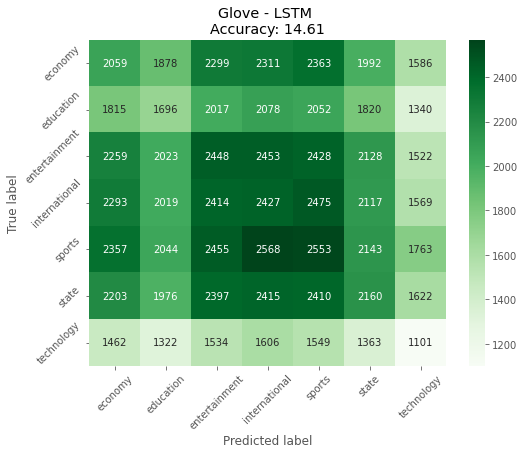

In [ ]:
test_pred
labels_test = label_encoding(test1,True)
y_test =  labels_test
y_pred = np.argmax(test_pred, axis=1)

y_pred
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
cm = confusion_matrix(y_test, y_pred) 

class_names = ['economy','education','entertainment','international','sports','state','technology']
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = class_names, 
                     columns = class_names)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens", fmt='g')
plt.title('Glove - LSTM \nAccuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

In [ ]:
class_names = ['economy','education','entertainment','international','sports','state','technology']
report = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, output_dict=True)).transpose()
report = report.rename(index={'0': 'economy','1':'education','2':'entertainment','3':'international','4':'sports','5':'state',                             '6': 'technology','7':'International'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

,precision,recall,f1-score,support
economy,14.25,14.21,14.23,14488.00000
education,13.09,13.23,13.16,12818.00000
entertainment,15.73,16.04,15.88,15261.00000
international,15.30,15.85,15.57,15314.00000
sports,16.13,16.07,16.10,15883.00000
state,15.74,14.23,14.94,15183.00000
technology,10.48,11.08,10.77,9937.00000
accuracy,14.61,14.61,14.61,0.14607
macro avg,14.39,14.39,14.38,98884.00000
weighted avg,14.64,14.61,14.62,98884.00000


In [ ]:
sub=pd.DataFrame({'True':y_test,'Pred_Bert':y_pred})
sub.to_csv('Evaluation_Glove_LSTM.csv',index=False)

In [ ]:
gc.collect()